# Multi Layer Perceptron

In [1]:
import sys
import os

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES, TIKTOK_MLP_SWEM_METRICS_PATH

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


In [3]:
from src.preprocesamiento.nlp_spacy import Tokenizer
import numpy as np
tokenizer = Tokenizer()

dataset_train_tokenized = {}
dataset_val_tokenized = {}
dataset_test_tokenized = {}

dataset_train_tokenized['tokens'] = tokenizer.tokenize(dataset_train['text'])
dataset_val_tokenized['tokens'] = tokenizer.tokenize(dataset_val['text'])
dataset_test_tokenized['tokens'] = tokenizer.tokenize(dataset_test['text'])

dataset_train_tokenized['polarity'] = dataset_train['polarity'].to_numpy().reshape(-1, 1)
dataset_val_tokenized['polarity'] = dataset_val['polarity'].to_numpy().reshape(-1,1)
dataset_test_tokenized['polarity'] = dataset_test['polarity'].to_numpy().reshape(-1,1)

Modelo cargado: es_core_news_sm


## Entrenar MLP

Hiperparámetros

In [ ]:
import numpy as np
from src.trainers.utils import ModelArgs, EarlyStopping 
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

list_pooling = ["aver", "max"]
list_optim = ["adam", "sgd"]
batch_size = 128
list_lr = np.logspace(-4, 1, 10)
print(list_lr)
epochs = 100

patience = None
min_delta = 1e-4
early_stopping = EarlyStopping(patience, min_delta)

num_workers = 0
pin_memory = False

model_args = ModelArgs()
model_args.hidden_layers = [128, 64, 32] # 128 bad
model_args.output_size = 3
model_args.dropout = 0.20

[1.00000000e-04 3.59381366e-04 1.29154967e-03 4.64158883e-03
 1.66810054e-02 5.99484250e-02 2.15443469e-01 7.74263683e-01
 2.78255940e+00 1.00000000e+01]


Device: cpu


100%|██████████| 100/100 [00:30<00:00,  3.28it/s, loss=0.793]


MLP SWEM aver adam 0.0001 ([128, 64, 32]) 0.2: 0.33820530251529574
Device: cpu


100%|██████████| 100/100 [00:32<00:00,  3.10it/s, loss=0.962]


MLP SWEM aver adam 0.00035938136638046257 ([128, 64, 32]) 0.2: 0.3416043507817811
Device: cpu


100%|██████████| 100/100 [00:30<00:00,  3.27it/s, loss=1.3] 


MLP SWEM aver adam 0.001291549665014884 ([128, 64, 32]) 0.2: 0.3558803535010197
Device: cpu


  2%|▏         | 2/100 [00:00<00:43,  2.26it/s, loss=0.823]


KeyboardInterrupt: 

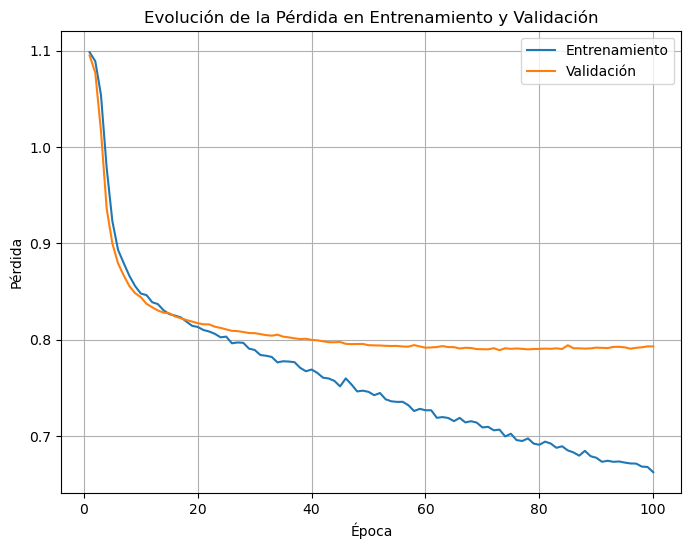

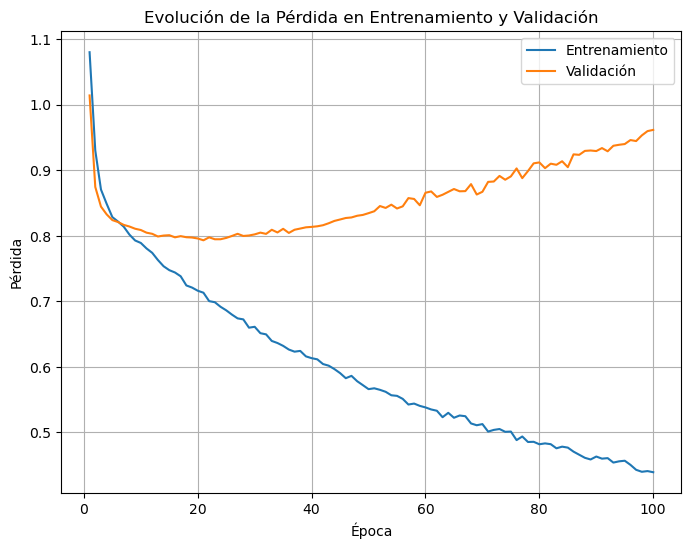

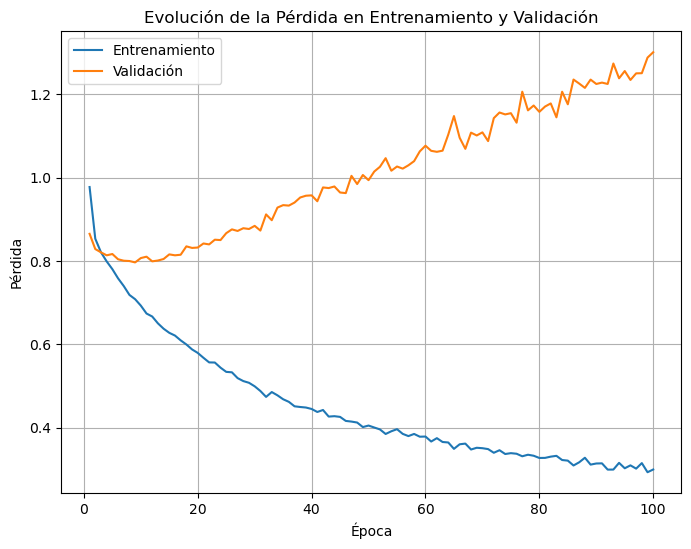

In [8]:
import os
from src.trainers.train_mlp import train_swem_mlp
from src.trainers.utils import show_loss_val_curves
from constants.constants_tiktok import MLP_SWEM_LOSS_CURVES_DIR

for pooling in list_pooling:
    for optim in list_optim:
        for lr in list_lr:
            model, metrics, train_losses, val_losses = train_swem_mlp(
                dataset_train=dataset_train_tokenized,
                dataset_val=dataset_val_tokenized,
                embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
                model_args=model_args,
                early_stopping=early_stopping,
                batch_size=batch_size,
                lr=lr,
                epochs=epochs,
                optim=optim,
                pooling=pooling,
                num_workers=num_workers,
                pin_memory=pin_memory
            )
            print(f"MLP SWEM {pooling} {optim} {lr} ({model_args.hidden_layers}) {model_args.dropout}: {metrics['accuracy']}")
            save_metrics(metrics, TIKTOK_MLP_SWEM_METRICS_PATH)
            title = f"MLP_SWEM_{metrics['pooling']}_{metrics['optim']} {'-'.join(str(lr).split('.'))}"
            path = os.path.join(MLP_SWEM_LOSS_CURVES_DIR, f"{title}.png")
            show_loss_val_curves(train_losses, val_losses, len(train_losses), path)

## Modelo con mayor accuracy

In [4]:
import pandas as pd
# Seleccionar los hiperparámetros que generan mayor accuracy
df_metrics = pd.read_csv(TIKTOK_MLP_SWEM_METRICS_PATH)

best_acc = df_metrics.loc[df_metrics['accuracy'].idxmax()]
print(best_acc)

accuracy               0.35588
recall                0.355883
precision             0.355943
f1_score              0.355874
model                 MLP SWEM
pooling                   aver
optim                     adam
lr                    0.001292
patience                   NaN
min_delta               0.0001
hidden_layers    [128, 64, 32]
output_size                  3
dropout                    0.2
epochs                     100
batch_size                 128
embedding_dim              100
train_time           30.543442
Name: 2, dtype: object


In [6]:
import re
from src.trainers.utils import ModelArgs, EarlyStopping 

pooling = best_acc["pooling"]
optim = best_acc["optim"]
lr = best_acc["lr"]
batch_size = 128
patience = best_acc['patience']
min_delta = best_acc['min_delta']
epochs = int(best_acc['epochs'])
if not np.isnan(patience): # early stopping
    epochs = int(epochs - patience)
early_stopping = EarlyStopping(patience, min_delta)
model_args = ModelArgs()
hidden_layers = re.findall(r'\d+', best_acc['hidden_layers'])
model_args.hidden_layers = list(map(int, hidden_layers))
model_args.output_size = 3
model_args.dropout = best_acc['dropout']

# opcional
num_workers = 0
pin_memory = False

Device: cpu


100%|██████████| 100/100 [00:31<00:00,  3.21it/s, loss=1.31]


Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\mlp_swem_model.pth

MLP SWEM
Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.34      0.34      0.34      1002
           1       0.34      0.33      0.34      1013
           2       0.31      0.33      0.32       927

    accuracy                           0.33      2942
   macro avg       0.33      0.33      0.33      2942
weighted avg       0.33      0.33      0.33      2942

Matriz de confusión


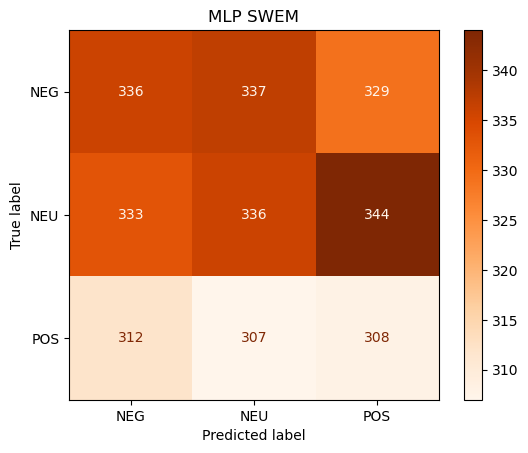

{'accuracy': 0.33310673011556763, 'recall': 0.33311004320178633, 'precision': 0.33309066042682567, 'f1_score': 0.33297058920380257}


In [8]:
from src.trainers.train_mlp import train_swem_mlp, evaluate_model
from src.trainers.utils import save_model_mlp
from constants.constants_tiktok import MLP_SWEM_MODEL_PATH
from constants.constants_tiktok import EMBEDDING_W2V_TIKTOK_SENTENCES_PATH

model, metrics, train_losses, val_losses = train_swem_mlp(
    dataset_train=dataset_train_tokenized,
    dataset_val=dataset_val_tokenized,
    embeddings_path=EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    model_args=model_args,
    early_stopping=early_stopping,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    optim=optim,
    pooling=pooling,
    num_workers=num_workers,
    pin_memory=pin_memory
)

save_model_mlp(model.get_model(), MLP_SWEM_MODEL_PATH)

metrics = evaluate_model(
    model,
    dataset_test_tokenized,
    "MLP SWEM",
    EMBEDDING_W2V_TIKTOK_SENTENCES_PATH,
    pooling,
    batch_size,
    num_workers,
    pin_memory
)
print(metrics)

In [ ]:
from src.trainers.train_mlp import MLPModelCustom
from constants.constants_tiktok import MLP_SWEM_MODEL_PATH
from src.trainers.utils import SentimentAnalysis, load_model_mlp

model = MLPModelCustom(best_acc['embedding_dim'], model_args.hidden_layers, 3)
model = load_model_mlp(model, MLP_SWEM_MODEL_PATH)
cls = SentimentAnalysis(model, "cpu", "aver")

Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\classifiers\mlp_swem_model.pth
Modelo cargado: es_core_news_sm
[('NEU', 0.9893961548805237), ('NEG', 0.008708005771040916), ('POS', 0.001895884983241558)]
[('NEU', 0.8425159454345703), ('POS', 0.15404869616031647), ('NEG', 0.003435352351516485)]
[('POS', 0.9518886208534241), ('NEU', 0.04744410887360573), ('NEG', 0.0006672288873232901)]


c:\Users\Diego\Desktop\sentiment_analysis\src\trainers\utils.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [10]:

from src.preprocesamiento.clean import clean_text
from src.preprocesamiento.nlp_spacy import preprocesamiento

textos_test = ["Hola! cómo estás???😀","el dia de hoy estoy feliz y contento", "estoy muy triste", "Me encuentro estudiando para un exámen", "A veces me encuentro triste, pero la mayoria del tiempo estoy muy feliz"]
textos_test = list(map(lambda x: clean_text(x), textos_test))
textos_test = preprocesamiento(textos_test)
for texto in textos_test:
    print(cls.predict(texto))

Modelo cargado: es_core_news_sm


100%|██████████| 5/5 [00:00<00:00, 1194.41it/s]
5it [00:00, 407.07it/s]

Aplicando stemming...
Total de documentos preprocesados: 5
[('NEU', 0.939582109451294), ('POS', 0.06041789427399635), ('NEG', 1.2533648563461952e-09)]
[('POS', 0.998838484287262), ('NEU', 0.0011615632101893425), ('NEG', 4.279084864222682e-10)]
[('NEG', 0.9999792575836182), ('NEU', 2.074144867947325e-05), ('POS', 1.073906516318379e-22)]
[('NEU', 0.9999532699584961), ('NEG', 4.672726208809763e-05), ('POS', 1.1046242143208929e-08)]
[('NEG', 0.9415249824523926), ('NEU', 0.03322776034474373), ('POS', 0.02524726651608944)]
